In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# **Loading data and creating Signals objects**

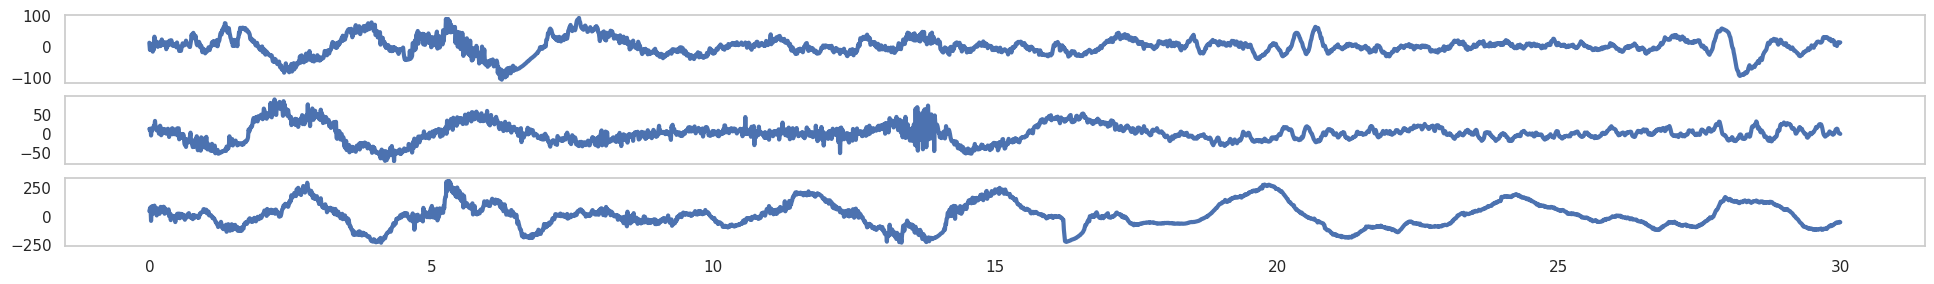

In [10]:
from msr.data.download.sleep_edf import load_sleep_edf_raw_tensors_for_split, FS
from msr.data.measurements import SleepEDFMeasurement

data, targets = load_sleep_edf_raw_tensors_for_split("val")
data, targets = data.numpy(), targets.numpy()
sample = data[111]
eeg_0, eeg_1, eog = sample
measurement = SleepEDFMeasurement(eeg_0, eeg_1, eog, FS)
eeg_sig = measurement['eeg_0']

measurement.plot(0, 30)

{'basic__mean': -0.22604118844119542,
 'basic__std': 27.952594102686135,
 'basic__median': 0.2368742368742295,
 'basic__skewness': -0.3174131216056651,
 'basic__kurtosis': 1.3348795401472051,
 'basic__energy': 2344195.835065196,
 'peaks_troughs__peaks__mean': 4.858247875482337,
 'peaks_troughs__peaks__std': 29.11468257803433,
 'peaks_troughs__peaks__median': 3.932112332112325,
 'peaks_troughs__peaks__skewness': -0.26956457618827684,
 'peaks_troughs__peaks__kurtosis': 1.2164632021168025,
 'peaks_troughs__peaks__energy': 2608574.3382337415,
 'peaks_troughs__troughs__mean': -5.145250207374463,
 'peaks_troughs__troughs__std': 28.030252675739288,
 'peaks_troughs__troughs__median': -3.4583638583638656,
 'peaks_troughs__troughs__skewness': -0.5656061154207935,
 'peaks_troughs__troughs__kurtosis': 1.5175118213261882,
 'peaks_troughs__troughs__energy': 2431632.9822982694,
 'peaks_troughs__amplitudes__mean': 10.0034980828568,
 'peaks_troughs__amplitudes__std': 11.760791765527488,
 'peaks_troughs

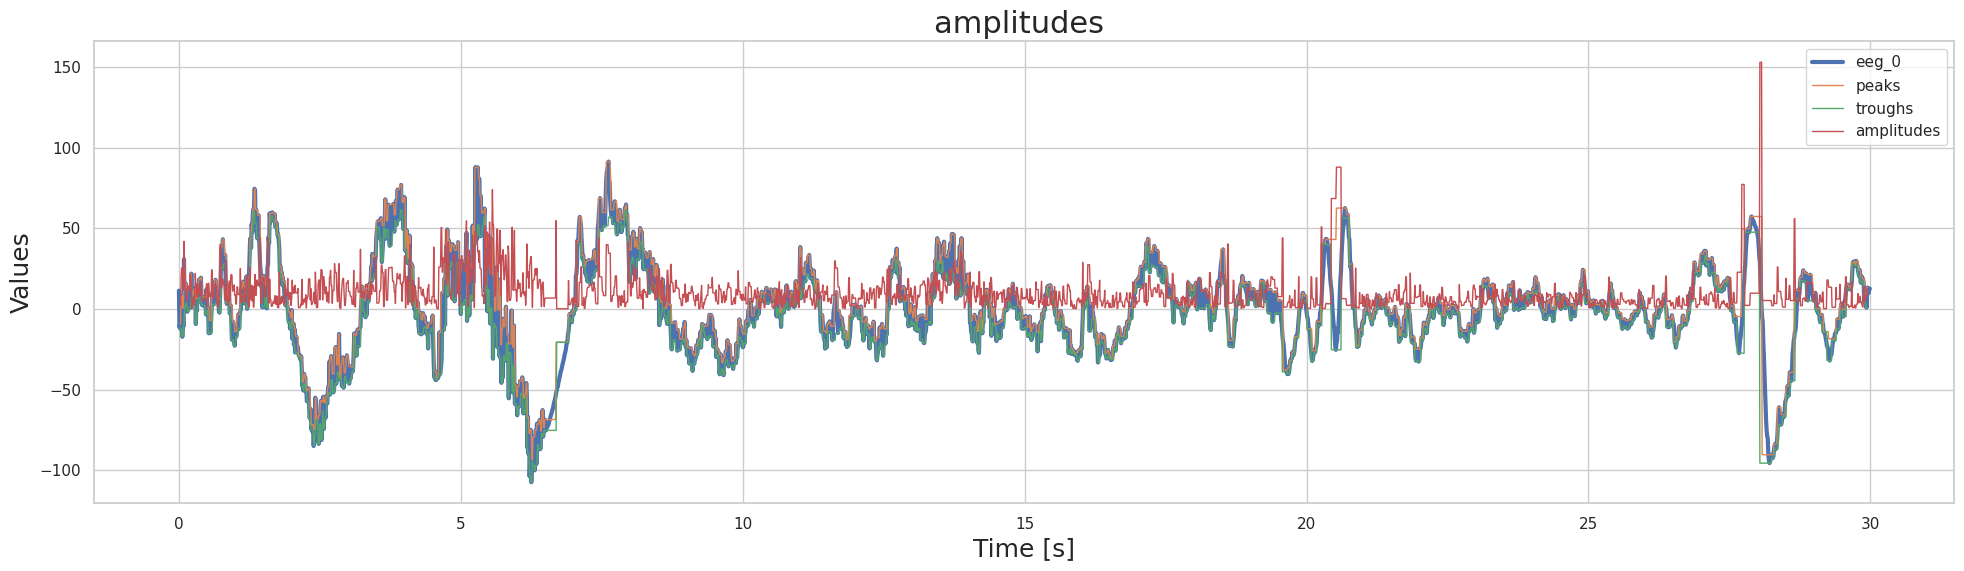

In [15]:
eeg_sig.extract_features(return_arr=False, plot=True)

In [16]:
import numpy as np

In [24]:
FS = 10000
t = np.arange(0, 0.2, 1/FS)

fc = 100
fm = 30

b = 5


frm = np.cos(2 * np.pi * fc * t + b + np.sin(2 * np.pi * fm * t))
m = np.sin(2 * np.pi * fm * t)

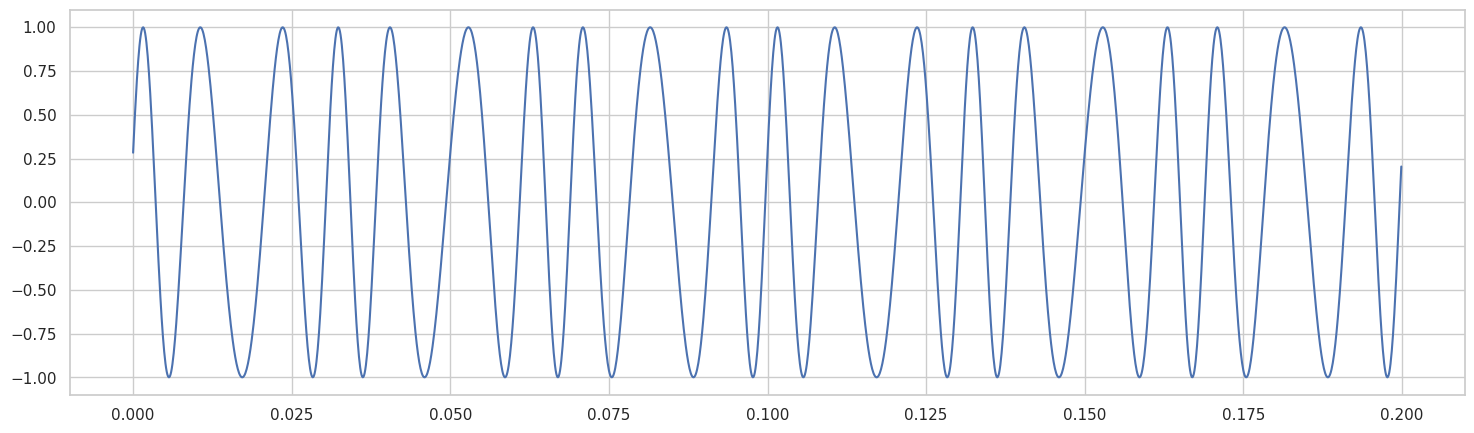

In [25]:
plt.figure(figsize=(18, 5))
plt.plot(t, frm)

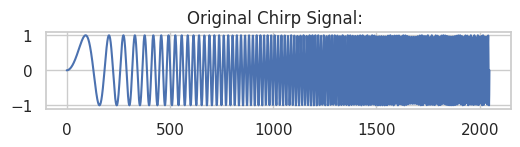

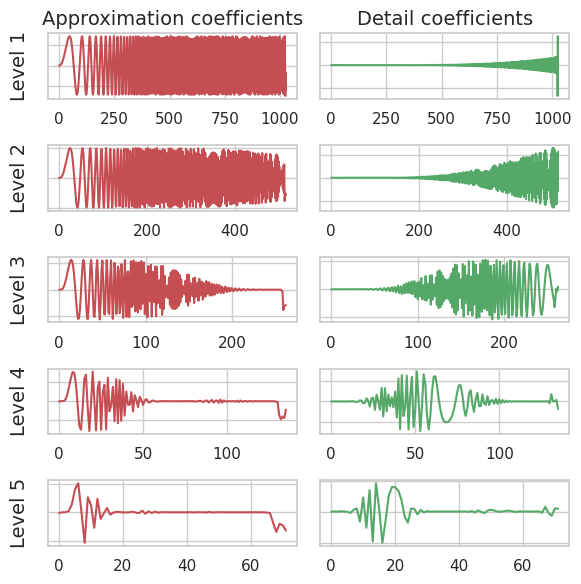

In [39]:
import pywt

x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [73]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.viridis, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    # levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    # contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, frequencies, power, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    # yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    # ax.set_yticks(np.log2(yticks))
    # ax.set_yticklabels(yticks)
    # ax.invert_yaxis()
    ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()


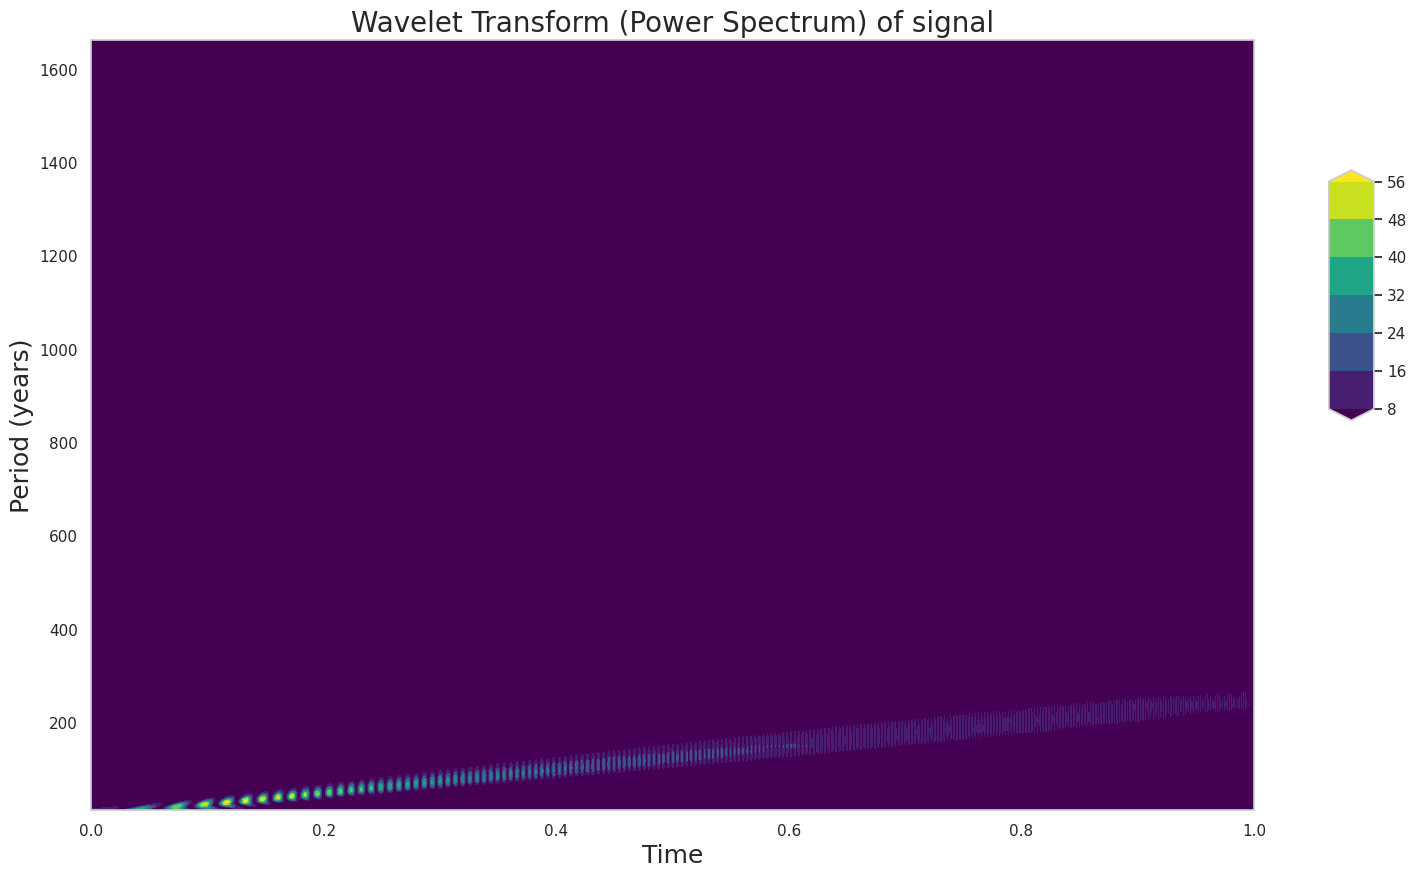

In [74]:
scales = np.arange(1, 128)

plot_wavelet(x, chirp_signal, scales, waveletname='morl')

In [ ]:
pywt.dwt(data, waveletname)

In [82]:
[len(coeff) for coeff in coeffs]

[24, 24, 40, 72, 136, 263, 518, 1028]

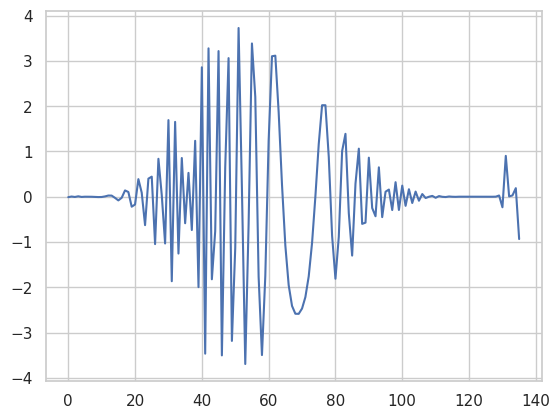

In [95]:
plt.plot(coeffs[4])

In [125]:
get_features(x)

{'entropy': 4.605170185988092,
 'num_of_zero_crossings': 55,
 'num_of_mean_crossings': 53,
 'percentile_5': -1.5612892264111669,
 'percentile_25': -0.8244165293287904,
 'percentile_75': 0.7253535652017193,
 'percentile_95': 1.7173258048970226,
 'median': 0.11618402806023992,
 'mean': 0.020245890149079467,
 'std': 1.0145095955761823,
 'var': 1.0292297195161488,
 'root_mean_square': 0.8337701063497412}

In [103]:
x = np.random.randn(100)

In [106]:
np.diff(x > 0)

array([False,  True, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False,  True, False,
        True, False, False, False, False,  True, False,  True, False,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True,  True,  True])

In [166]:
import pywt
from scipy.stats import entropy
from collections import Counter

def calculate_entropy(arr):
    counter_values = Counter(arr).most_common()
    probs = [el[1]/len(arr) for el in counter_values]
    return {"entropy": entropy(probs)}

def calculate_statistics(arr):
    return {
        "percentile_5": np.percentile(arr, 5), 
        "percentile_25": np.percentile(arr, 25), 
        "percentile_75": np.percentile(arr, 75), 
        "percentile_95": np.percentile(arr, 95), 
        "median": np.median(arr), 
        "mean": np.mean(arr), 
        "std": np.std(arr), 
        "var": np.var(arr), 
        "root_mean_square": np.mean(np.sqrt(arr**2))
    }

def calculate_zerocross_feats(arr, thr=0):
    zerocross_idxs = np.nonzero(np.diff(x > thr))[0]
    
    first_zc_idx = max(0, zerocross_idxs[0] - 1)
    if x[first_zc_idx + 1] - x[first_zc_idx] > 0: # first zc is from minus to plus
        pos_zc_idxs = zerocross_idxs[::2]
        neg_zc_idxs = zerocross_idxs[1::2]
    else:
        neg_zc_idxs = zerocross_idxs[::2]
        pos_zc_idxs = zerocross_idxs[1::2]
        
    neg_zc_diffs = np.diff(neg_zc_idxs)
    pos_zc_diffs = np.diff(pos_zc_idxs)

    neg_zc_std = neg_zc_diffs.std()
    pos_zc_std = pos_zc_diffs.std()
    
    return {
        "cross_number": len(zerocross_idxs), 
        "pos_cross_std": pos_zc_std,
        "neg_cross_std": neg_zc_std,
    }

def get_basic_signal_features(arr):
    entropy = calculate_entropy(arr)
    zerocross = calculate_zerocross_feats(arr, thr=0)
    zerocross = {f"zero_{name}": value for name, value in zerocross.items()}
    meancross = calculate_zerocross_feats(arr, thr=arr.mean())
    meancross = {f"mean_{name}": value for name, value in meancross.items()}
    
    statistics = calculate_statistics(arr)
    return {**entropy, **zerocross , **meancross, **statistics}
    

def extract_dwt_features(signal, wavelet="db5", level=None):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    level = len(coeffs) - 1
    names = [f"approximation_{level}"] + [f"detail_{level - i}" for i in range(level)]
    features = {}
    for name, coeff in zip(names, coeffs):
        features[name] = get_basic_signal_features(coeff)
    return features

In [167]:
get_basic_signal_features(x)

{'entropy': 4.605170185988092,
 'zero_cross_number': 55,
 'zero_pos_cross_std': 1.705313249366124,
 'zero_neg_cross_std': 1.8223627293049438,
 'mean_cross_number': 53,
 'mean_pos_cross_std': 1.7443908416074718,
 'mean_neg_cross_std': 1.887220177933672,
 'percentile_5': -1.5612892264111669,
 'percentile_25': -0.8244165293287904,
 'percentile_75': 0.7253535652017193,
 'percentile_95': 1.7173258048970226,
 'median': 0.11618402806023992,
 'mean': 0.020245890149079467,
 'std': 1.0145095955761823,
 'var': 1.0292297195161488,
 'root_mean_square': 0.8337701063497412}